In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
import numpy as np

# Load the dataset
file_path = 'index2.csv'  # Update the path if necessary
df = pd.read_csv(file_path)
df.head()


,neighbourhood,lacking_canopy_z,pop_density_z,65plus_z,total_pop_z,homeowners_core_z,total_core_z,tennants_core_z,owners_30pct_shelter_z,total_30pct_shelter_z,...,non_citizens_z_VI,unsuitable_housing_z_VI,lico_aftertax_total_z_VI,lim_aftertax_total_z_VI,renters_z_VI,visible_minority_z_VI,unemployed_z_VI,temperature_z_VI,canopy_target_z_VI,unweighted_score
0,ABBOTTSFIELD,0.717509,1.001598,-1.014873,-0.688575,1.072485,1.487266,1.405917,0.212180,0.604482,...,4,6,6,6,4,4,3,5,4,160
1,ALBANY,1.383038,-0.869779,-1.114432,-0.731552,-0.115825,-0.777320,-0.875576,0.898069,0.289850,...,3,3,4,3,4,4,3,3,5,114
2,ALBERTA AVENUE,-1.545291,0.924028,-0.180230,1.093012,1.459977,1.243387,0.997047,0.261172,0.875065,...,3,4,4,4,4,4,5,3,2,140
3,ALDERGROVE,-0.081127,0.381038,-0.115439,0.676918,0.581661,0.546592,0.457339,-0.490040,0.308728,...,4,5,3,3,3,4,4,4,3,127
4,ALLARD,1.516144,1.593878,-1.461938,1.917387,-0.451652,-0.352275,-0.270449,0.702101,0.566726,...,5,4,3,3,3,5,3,4,5,121


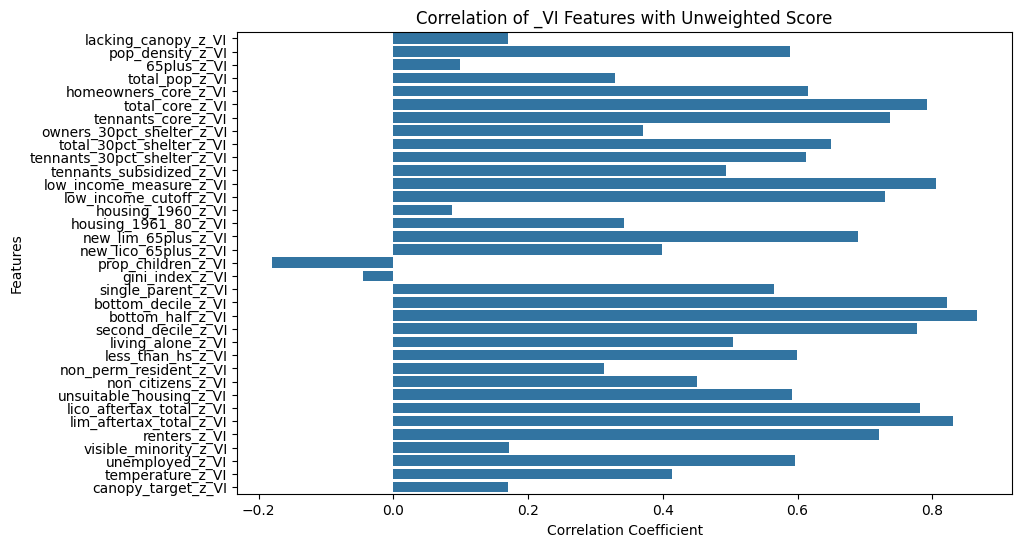

In [6]:
# Selecting only the columns ending with '_VI' and the 'unweighted_score'
vi_columns = [col for col in df.columns if col.endswith('_VI')]
vi_data = df[vi_columns + ['unweighted_score']]

# Calculating the correlation matrix
correlation_matrix = vi_data.corr()

# Isolating the correlation of features with 'unweighted_score'
correlation_with_unweighted_score = correlation_matrix['unweighted_score'].drop('unweighted_score')

# Visualizing the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_unweighted_score.values, y=correlation_with_unweighted_score.index)
plt.title('Correlation of _VI Features with Unweighted Score')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()


In [8]:
# Data Cleaning and Preprocessing

# Dropping the 'Unnamed: 0' column as it seems to be an index column
#df_cleaned = df.drop(columns=['Unnamed: 0'])

# Checking for missing values
missing_values = df.isnull().sum()

# Checking for duplicate rows
duplicate_rows = df.duplicated().sum()

# Summary of missing values and duplicates
missing_values_summary = missing_values[missing_values > 0]
duplicate_rows_summary = {'Duplicate Rows': duplicate_rows}

missing_values_summary, duplicate_rows_summary


(housing_1960_z          1
 housing_1961_80_z       1
 prop_children_z         1
 single_parent_z         1
 bottom_decile_z         1
 bottom_half_z           1
 second_decile_z         1
 living_alone_z          1
 less_than_hs_z          1
 non_perm_resident_z     1
 non_citizens_z          1
 unsuitable_housing_z    1
 renters_z               1
 visible_minority_z      1
 unemployed_z            1
 temperature_z           7
 dtype: int64,
 {'Duplicate Rows': 0})

In [11]:
# Excluding 'weighted_score' from the analysis
columns_with_missing = missing_values_summary.index.tolist()
#columns_with_missing.remove('weighted_score')

# Detailed analysis of columns with missing values
missing_data_analysis = {}
for column in columns_with_missing:
    column_data = df[column]
    missing_data_analysis[column] = {
        'Data Type': column_data.dtype,
        'Number of Missing Values': missing_values[column],
        'Percent Missing': (missing_values[column] / len(df)) * 100,
        'Mean Value': column_data.mean(),
        'Median Value': column_data.median(),
        'Mode Value': column_data.mode()[0]
    }

missing_data_analysis_df = pd.DataFrame.from_dict(missing_data_analysis, orient='index')
missing_data_analysis_df


,Data Type,Number of Missing Values,Percent Missing,Mean Value,Median Value,Mode Value
housing_1960_z,float64,1,0.364964,2.478832e-03,-0.558647,-0.676721
housing_1961_80_z,float64,1,0.364964,3.969334e-03,-0.176275,-1.083628
prop_children_z,float64,1,0.364964,-4.316379e-03,0.228578,0.446864
single_parent_z,float64,1,0.364964,2.374388e-03,-0.128068,-0.671798
bottom_decile_z,float64,1,0.364964,5.871764e-03,-0.180502,-1.602992
bottom_half_z,float64,1,0.364964,8.625724e-03,0.000380,-2.932682
second_decile_z,float64,1,0.364964,6.691133e-03,-0.094925,-1.826679
living_alone_z,float64,1,0.364964,3.610225e-03,-0.259846,-0.592336
less_than_hs_z,float64,1,0.364964,-4.086768e-05,-0.090812,-2.313568
non_perm_resident_z,float64,1,0.364964,2.187821e-03,-0.222664,-0.597275


In [12]:
# Excluding 'weighted_score' from the analysis
columns_with_missing = missing_values_summary.index.tolist()
#columns_with_missing.remove('weighted_score')

# Detailed analysis of columns with missing values
missing_data_analysis = {}
for column in columns_with_missing:
    column_data = df[column]
    missing_data_analysis[column] = {
        'Data Type': column_data.dtype,
        'Number of Missing Values': missing_values[column],
        'Percent Missing': (missing_values[column] / len(df)) * 100,
        'Mean Value': column_data.mean(),
        'Median Value': column_data.median(),
        'Mode Value': column_data.mode()[0]
    }

missing_data_analysis_df = pd.DataFrame.from_dict(missing_data_analysis, orient='index')
missing_data_analysis_df


,Data Type,Number of Missing Values,Percent Missing,Mean Value,Median Value,Mode Value
housing_1960_z,float64,1,0.364964,2.478832e-03,-0.558647,-0.676721
housing_1961_80_z,float64,1,0.364964,3.969334e-03,-0.176275,-1.083628
prop_children_z,float64,1,0.364964,-4.316379e-03,0.228578,0.446864
single_parent_z,float64,1,0.364964,2.374388e-03,-0.128068,-0.671798
bottom_decile_z,float64,1,0.364964,5.871764e-03,-0.180502,-1.602992
bottom_half_z,float64,1,0.364964,8.625724e-03,0.000380,-2.932682
second_decile_z,float64,1,0.364964,6.691133e-03,-0.094925,-1.826679
living_alone_z,float64,1,0.364964,3.610225e-03,-0.259846,-0.592336
less_than_hs_z,float64,1,0.364964,-4.086768e-05,-0.090812,-2.313568
non_perm_resident_z,float64,1,0.364964,2.187821e-03,-0.222664,-0.597275


In [14]:
# Performing imputation for the missing values
for column in columns_with_missing:
    # Deciding whether to use mean or median for imputation
    if abs(missing_data_analysis_df.loc[column, 'Mean Value'] - missing_data_analysis_df.loc[column, 'Median Value']) < 0.1:
        # Mean and median are close, so using mean for imputation
        impute_value = missing_data_analysis_df.loc[column, 'Mean Value']
    else:
        # Using mode for imputation when mean and median are not close
        impute_value = missing_data_analysis_df.loc[column, 'Mode Value']

    # Imputing missing values
    df[column].fillna(impute_value, inplace=True)

# Rechecking for missing values to ensure imputation was successful
df.isnull().sum().sum()


0

In [15]:
df.isnull().sum().sum()

0

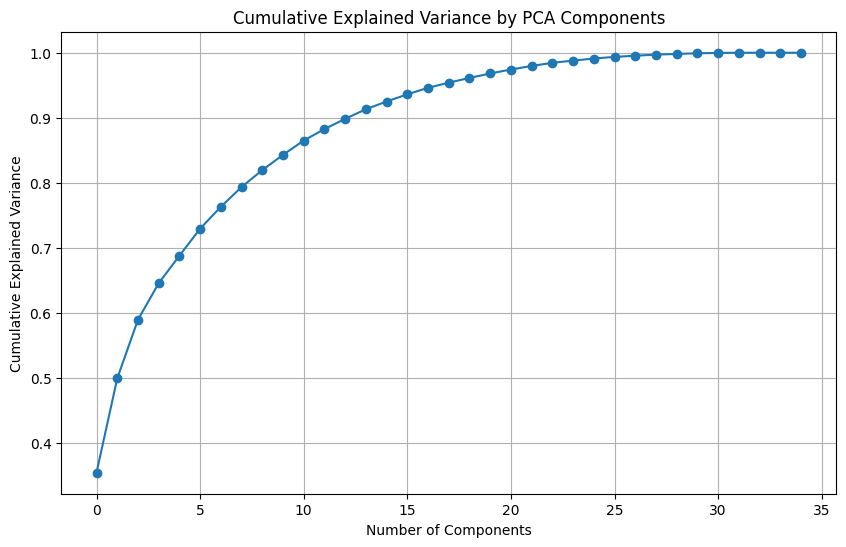

In [17]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
# Check if the required modules are imported
try:
    import matplotlib.pyplot as plt
except ImportError as e:
    print(f"Error: {e}")
    print("Please make sure you have the required modules installed.")

# Check if the necessary variables are defined
try:
    if 'df' not in locals():
        raise NameError("Variable 'df_cleaned' is not defined.")
except NameError as e:
    print(f"Error: {e}")
    print("Please make sure you have defined the necessary variables.")

# Selecting only the columns ending with '_z'
z_columns = [col for col in df.columns if col.endswith('_z')]

# Check if any columns ending with '_z' are found
if not z_columns:
    print("Error: No columns ending with '_z' found in the dataframe.")
else:
    # Extract the subset of the dataframe with '_z' columns
    X_z = df[z_columns]

    # Check if the subset dataframe is empty
    if X_z.empty:
        print("Error: Subset dataframe is empty.")
    else:
        try:
            # Performing PCA
            pca = PCA()
            pca.fit(X_z)

            # Getting the explained variance ratio for each principal component
            explained_variance_ratio = pca.explained_variance_ratio_

            # Check if explained variance ratio is empty
            if not explained_variance_ratio.any():
                print("Error: Explained variance ratio is empty.")
            else:
                # Plotting the cumulative explained variance
                cumulative_variance = np.cumsum(explained_variance_ratio)
                plt.figure(figsize=(10, 6))
                plt.plot(cumulative_variance, marker='o')
                plt.title('Cumulative Explained Variance by PCA Components')
                plt.xlabel('Number of Components')
                plt.ylabel('Cumulative Explained Variance')
                plt.grid(True)
                plt.show()
        except Exception as e:
            print(f"Error: {e}")
            print("An error occurred while performing PCA.")


In [18]:
pca_t = PCA(n_components=5, random_state=42)
pca_transformed = pca_t.fit_transform(X_z)


In [19]:
indicator_names = X_z.columns

# Get the loadings of each feature on each principal component
loadings = pca_t.components_

# Create a dictionary to store the indicators for each factor
factor_indicators = {}

# Iterate over each principal component
for i, component in enumerate(loadings):
    # Get the indices of the top features (indicators) for the current component
    top_feature_indices = np.argsort(np.abs(component))[::-1]
    
    # Get the top feature names (indicators) for the current component
    top_feature_names = indicator_names[top_feature_indices]
    
    # Store the top feature names (indicators) for the current component in the dictionary
    factor_indicators[f"Factor {i+1}"] = top_feature_names

# Print the indicators for each factor
for factor, indicators in factor_indicators.items():
    print(f"{factor}: {', '.join(indicators)}")


Factor 1: lim_aftertax_total_z, bottom_decile_z, low_income_measure_z, bottom_half_z, lico_aftertax_total_z, total_core_z, low_income_cutoff_z, second_decile_z, renters_z, tennants_core_z, new_lim_65plus_z, total_30pct_shelter_z, living_alone_z, tennants_30pct_shelter_z, homeowners_core_z, unemployed_z, less_than_hs_z, pop_density_z, single_parent_z, tennants_subsidized_z, unsuitable_housing_z, prop_children_z, housing_1961_80_z, temperature_z, new_lico_65plus_z, owners_30pct_shelter_z, non_citizens_z, housing_1960_z, non_perm_resident_z, total_pop_z, gini_index_z, 65plus_z, lacking_canopy_z, canopy_target_z, visible_minority_z
Factor 2: lacking_canopy_z, canopy_target_z, visible_minority_z, prop_children_z, housing_1960_z, temperature_z, unsuitable_housing_z, non_citizens_z, gini_index_z, total_pop_z, living_alone_z, pop_density_z, owners_30pct_shelter_z, less_than_hs_z, bottom_half_z, single_parent_z, low_income_cutoff_z, renters_z, housing_1961_80_z, 65plus_z, new_lim_65plus_z, tota

In [21]:
import numpy as np

# Define the number of iterations
num_iterations = 5

# Initialize lists to store the results for each iteration
explained_variance_ratios = np.empty(num_iterations, dtype=object)
num_components = np.empty(num_iterations, dtype=int)

# Run multiple iterations of PCA
for i in range(num_iterations):
    # Vary the number of components in each iteration
    n_components = i + 1

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_z)

    # Store the results
    explained_variance_ratios[i] = pca.explained_variance_ratio_
    num_components[i] = n_components

    # Print the results for each iteration
    print(f"Iteration {i+1}:")
    print("Explained Variance Ratio:", explained_variance_ratios[i])
    print("Number of components:", num_components[i])
    print()

# Compare the results

# Find the index of the maximum explained variance ratio
max_variance_ratio_index = np.argmax([np.max(ratio) for ratio in explained_variance_ratios])
max_variance_ratio = explained_variance_ratios[max_variance_ratio_index]
max_components = num_components[max_variance_ratio_index]

# Print the best result
print("Best Result:")
print("Explained Variance Ratio:", max_variance_ratio)
print("Number of components:", max_components)


Iteration 1:
Explained Variance Ratio: [0.36504872]
Number of components: 1

Iteration 2:
Explained Variance Ratio: [0.36504872 0.14850618]
Number of components: 2

Iteration 3:
Explained Variance Ratio: [0.36504872 0.14850618 0.09287457]
Number of components: 3

Iteration 4:
Explained Variance Ratio: [0.36504872 0.14850618 0.09287457 0.05774192]
Number of components: 4

Iteration 5:
Explained Variance Ratio: [0.36504872 0.14850618 0.09287457 0.05774192 0.04281866]
Number of components: 5

Best Result:
Explained Variance Ratio: [0.36504872]
Number of components: 1


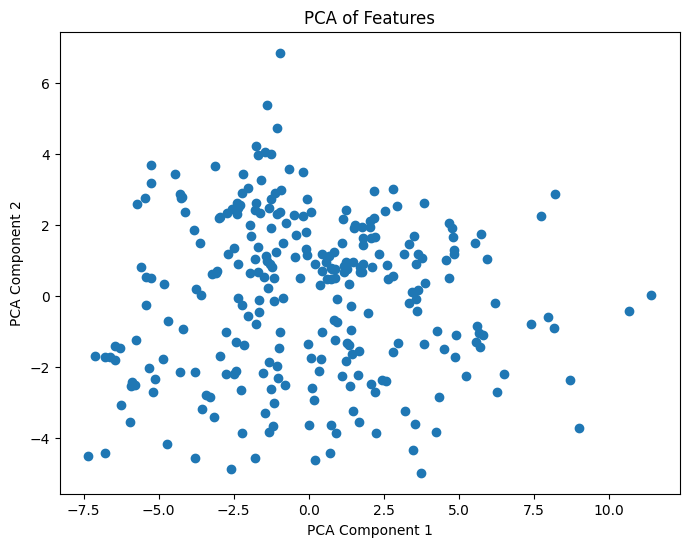

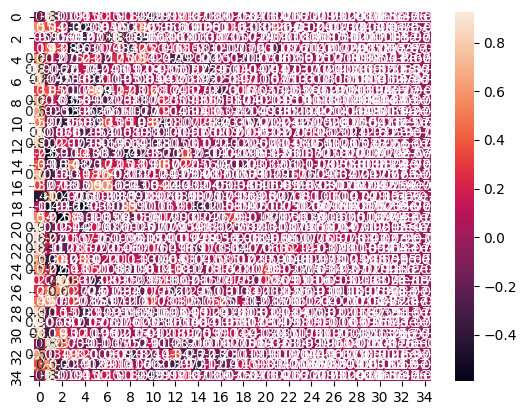

In [20]:

# Define X_pca before using it
X_pca = pca.transform(X_z)

# Scatter plot for first two PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Features')
plt.show()

# Correlation of original features with PCA components
correlation_matrix = np.corrcoef(X_z.T, X_pca.T)[:len(X_z.columns), len(X_z.columns):]
sns.heatmap(correlation_matrix, annot=True)
plt.show()


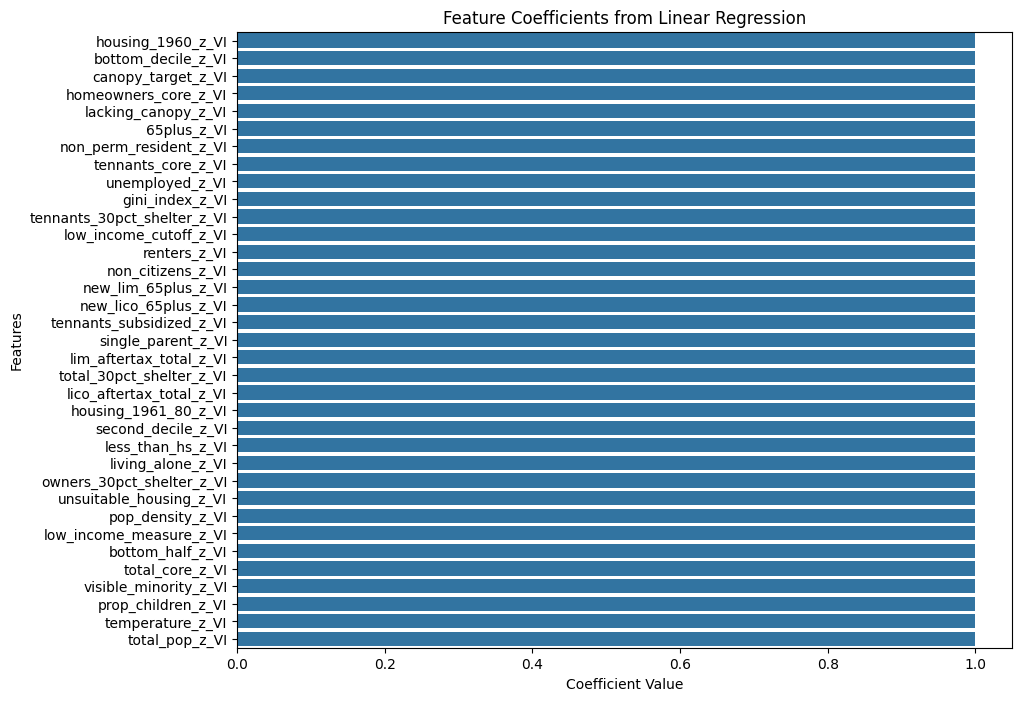

housing_1960_z_VI              1.0
bottom_decile_z_VI             1.0
canopy_target_z_VI             1.0
homeowners_core_z_VI           1.0
lacking_canopy_z_VI            1.0
65plus_z_VI                    1.0
non_perm_resident_z_VI         1.0
tennants_core_z_VI             1.0
unemployed_z_VI                1.0
gini_index_z_VI                1.0
tennants_30pct_shelter_z_VI    1.0
low_income_cutoff_z_VI         1.0
renters_z_VI                   1.0
non_citizens_z_VI              1.0
new_lim_65plus_z_VI            1.0
new_lico_65plus_z_VI           1.0
tennants_subsidized_z_VI       1.0
single_parent_z_VI             1.0
lim_aftertax_total_z_VI        1.0
total_30pct_shelter_z_VI       1.0
lico_aftertax_total_z_VI       1.0
housing_1961_80_z_VI           1.0
second_decile_z_VI             1.0
less_than_hs_z_VI              1.0
living_alone_z_VI              1.0
owners_30pct_shelter_z_VI      1.0
unsuitable_housing_z_VI        1.0
pop_density_z_VI               1.0
low_income_measure_z

In [21]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Preparing the data for regression analysis
X = df[vi_columns]  # Independent variables
y = df['unweighted_score']  # Dependent variable

# Performing the regression analysis
linear_reg = LinearRegression()
linear_reg.fit(X, y)

# Extracting the coefficients
feature_coefficients = pd.Series(linear_reg.coef_, index=X.columns)

# Sorting the coefficients for better visualization
sorted_feature_coefficients = feature_coefficients.sort_values(key=abs, ascending=False)

# Visualizing the coefficients
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_feature_coefficients.values, y=sorted_feature_coefficients.index)
plt.title('Feature Coefficients from Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

sorted_feature_coefficients


Fitting 4 folds for each of 1152 candidates, totalling 4608 fits


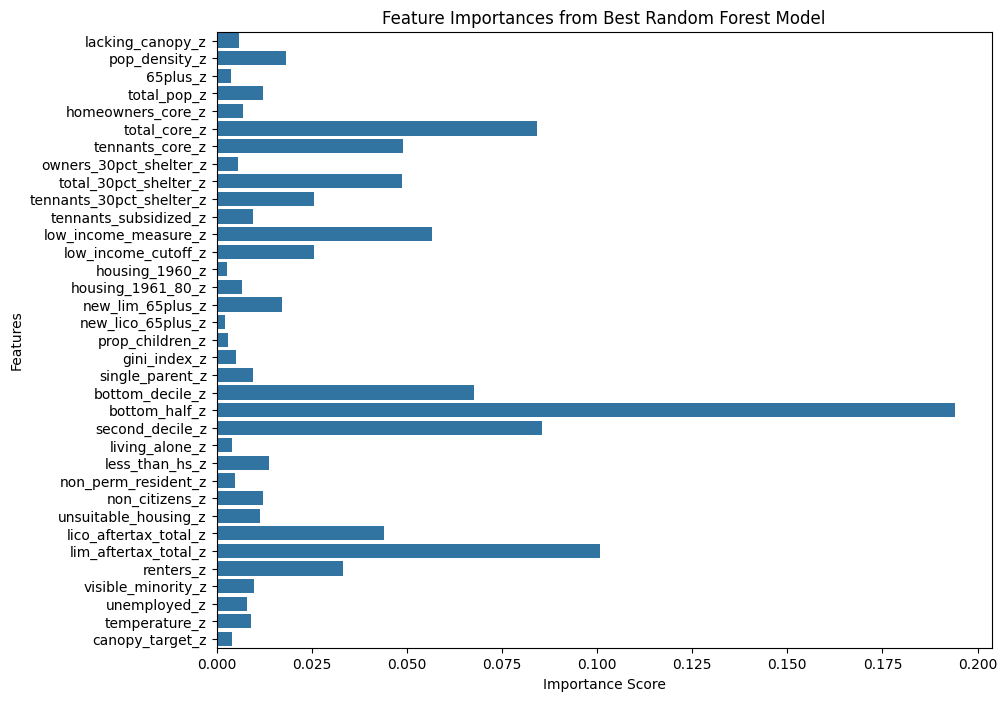

Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score for Random Forest: 0.9047619306201158


In [22]:
from sklearn.model_selection import GridSearchCV
# Robust Random Forest with GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42,n_jobs=-1)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=4, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_z, y)

best_rf_model = grid_search_rf.best_estimator_

# Feature importances from the best Random Forest model
rf_feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_z.columns)

# Visualizing feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=rf_feature_importances.values, y=rf_feature_importances.index)
plt.title('Feature Importances from Best Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Best parameters and score for Random Forest
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Score for Random Forest:", grid_search_rf.best_score_)


In [23]:
rf_feature_importances

lacking_canopy_z            0.005908
pop_density_z               0.018265
65plus_z                    0.003880
total_pop_z                 0.012178
homeowners_core_z           0.006842
total_core_z                0.084100
tennants_core_z             0.048994
owners_30pct_shelter_z      0.005571
total_30pct_shelter_z       0.048681
tennants_30pct_shelter_z    0.025684
tennants_subsidized_z       0.009658
low_income_measure_z        0.056476
low_income_cutoff_z         0.025595
housing_1960_z              0.002660
housing_1961_80_z           0.006647
new_lim_65plus_z            0.017128
new_lico_65plus_z           0.002121
prop_children_z             0.003051
gini_index_z                0.005139
single_parent_z             0.009425
bottom_decile_z             0.067646
bottom_half_z               0.193990
second_decile_z             0.085447
living_alone_z              0.003927
less_than_hs_z              0.013818
non_perm_resident_z         0.004838
non_citizens_z              0.012231
u

Fitting 4 folds for each of 600 candidates, totalling 2400 fits


c:\Users\toast\Documents\GitHub\spatial_stats\spatial_stats_py\.venv\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan n

Best neg_mean_squared_error: 0.4860837149333942
Best explained_variance: 0.6982016578051307
Best r2: 0.8457859913192283
Best neg_median_absolute_error: 0.8847623329969414
Best f1: 0.8982361820161384


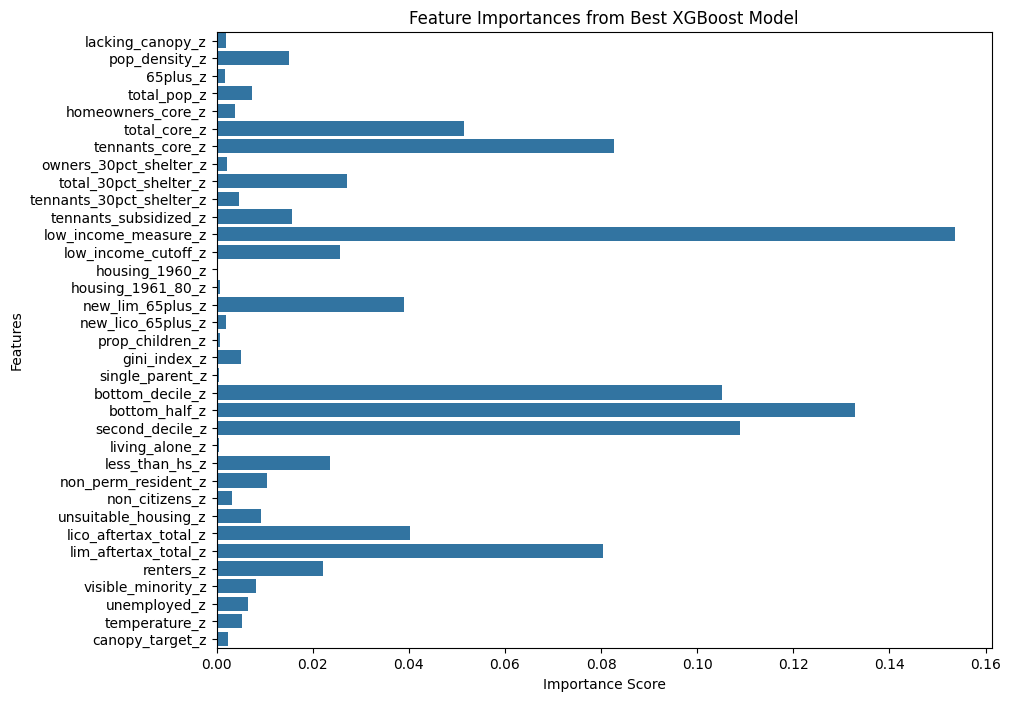

In [26]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns


# Define the expanded parameter grid for XGBoost

param_grid = {
    "n_estimators": [50, 100, 200, 300, 400, 500],
    "max_depth": [3, 6, 10, 15, 20],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "colsample_bytree": [0.3, 0.5, 0.7, 1.0]
}

# Define the scoring map with multiple metrics
scoring = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "explained_variance": "explained_variance",
    "r2": "r2",
    "neg_median_absolute_error": "neg_median_absolute_error",
    'f1': 'f1',
}


# Create the XGBoost model

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)


# Set up GridSearchCV with parallelization
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scoring,
    cv=4,  # Increase number of cross-validation folds
    verbose=1,
    n_jobs=-1,
    refit="explained_variance",
)


# Fit the GridSearchCV

grid_search.fit(X_z, y)


# Best parameters and best scores for each metric

best_params = grid_search.best_params_

best_scores = grid_search.cv_results_["mean_test_explained_variance"]

# Convert best_scores to a dictionary
best_scores_dict = {
    metric: score for metric, score in zip(scoring.keys(), best_scores.tolist())
}

# Create an XGBoost model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
best_xgb_model.fit(X_z, y)

# Feature importances from the best model
best_xgb_feature_importances = pd.Series(
    best_xgb_model.feature_importances_, index=X_z.columns
)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=best_xgb_feature_importances.values, y=best_xgb_feature_importances.index)
plt.title("Feature Importances from Best XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
for metric, score in best_scores_dict.items():
    print(f"Best {metric}: {score}")


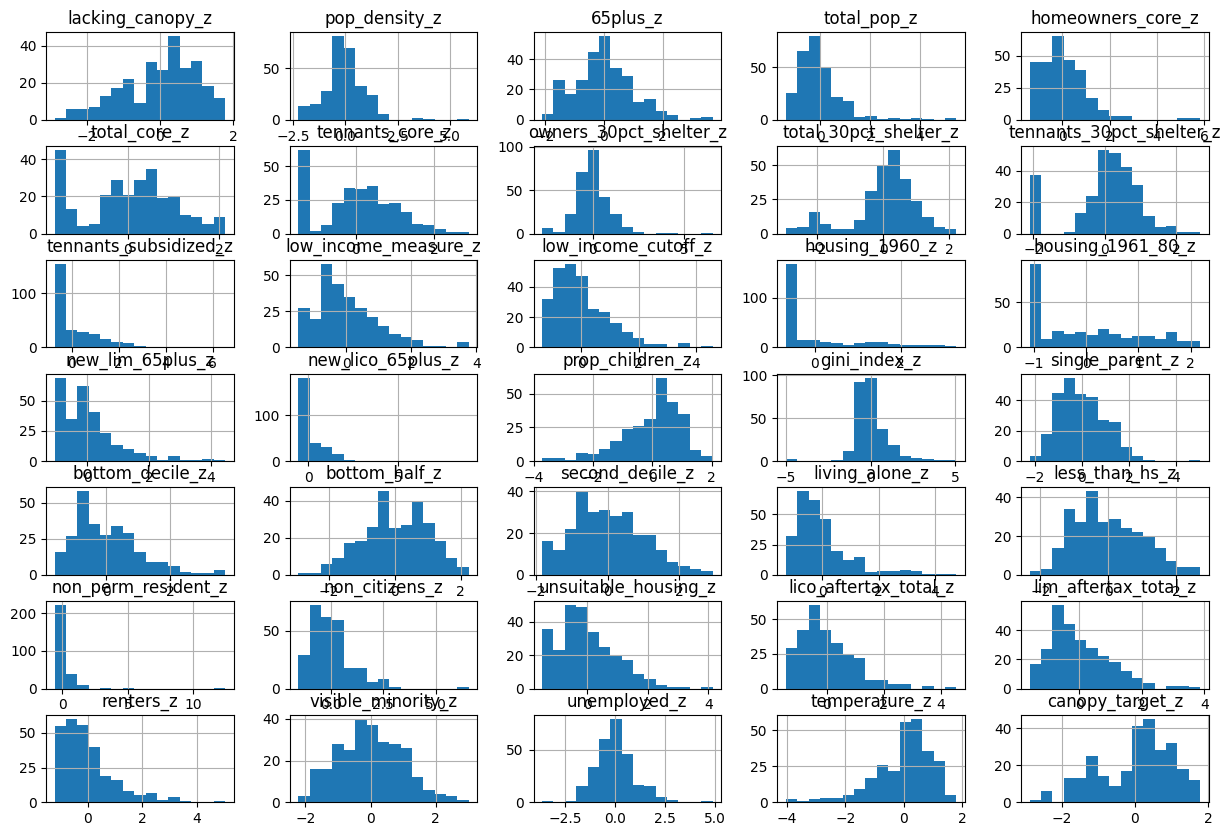

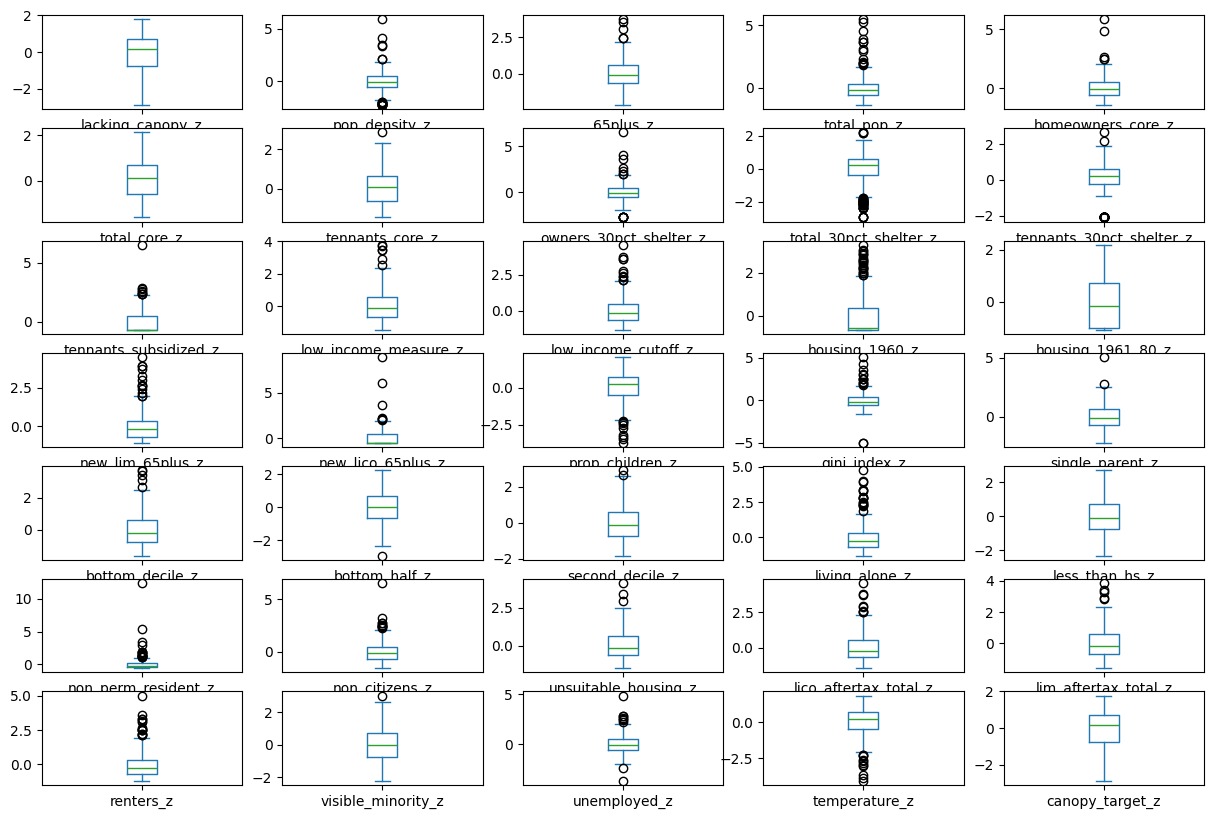

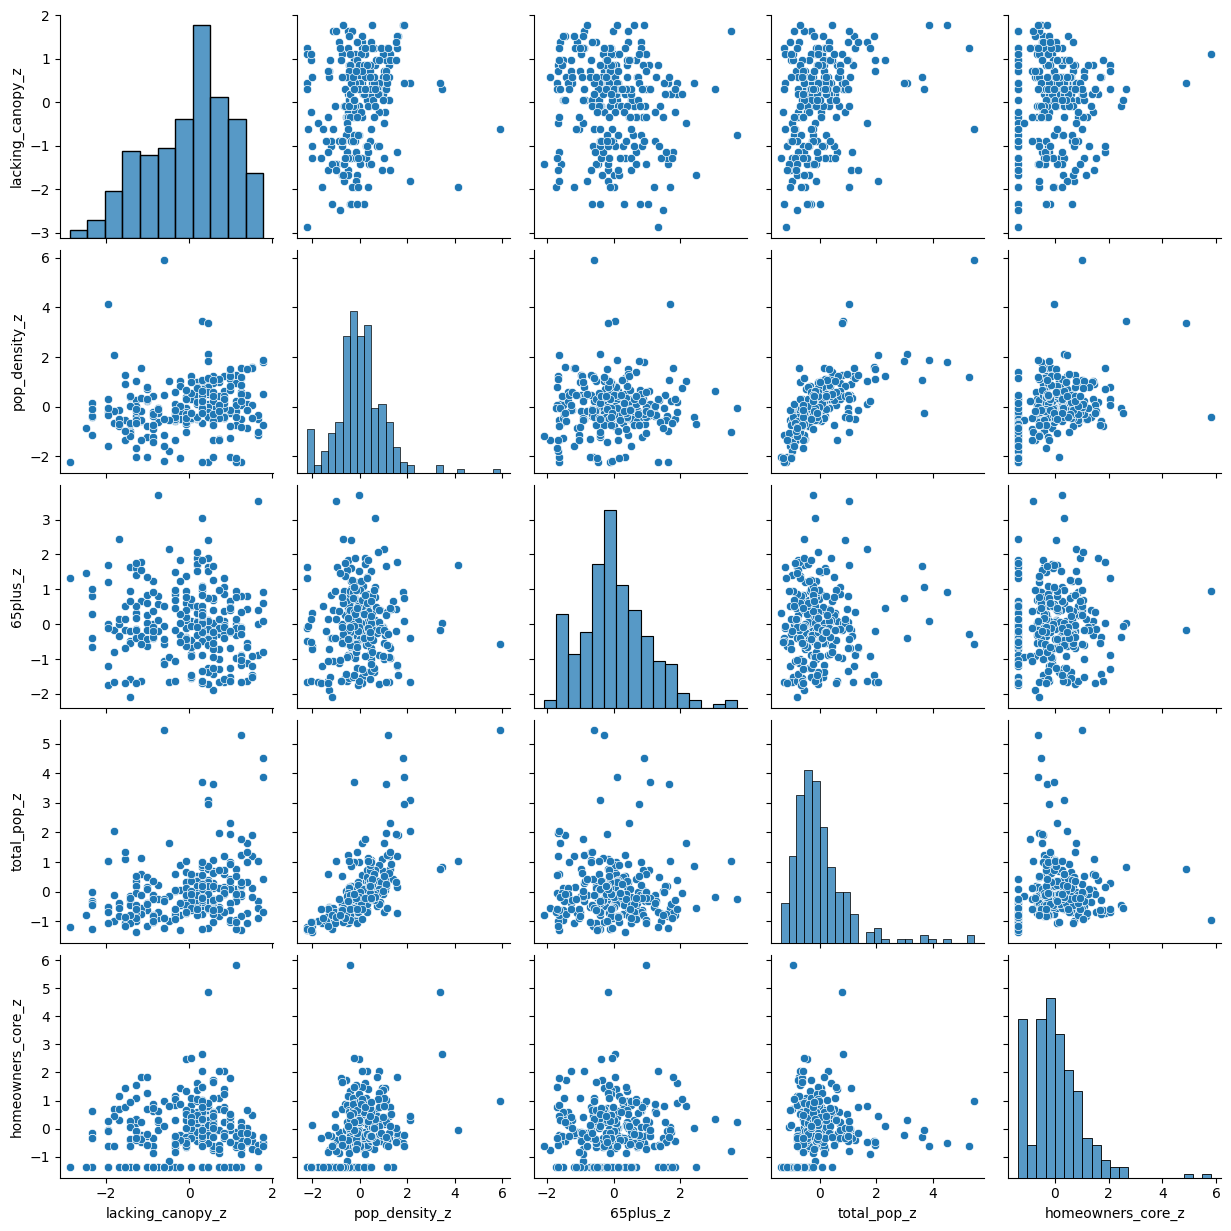

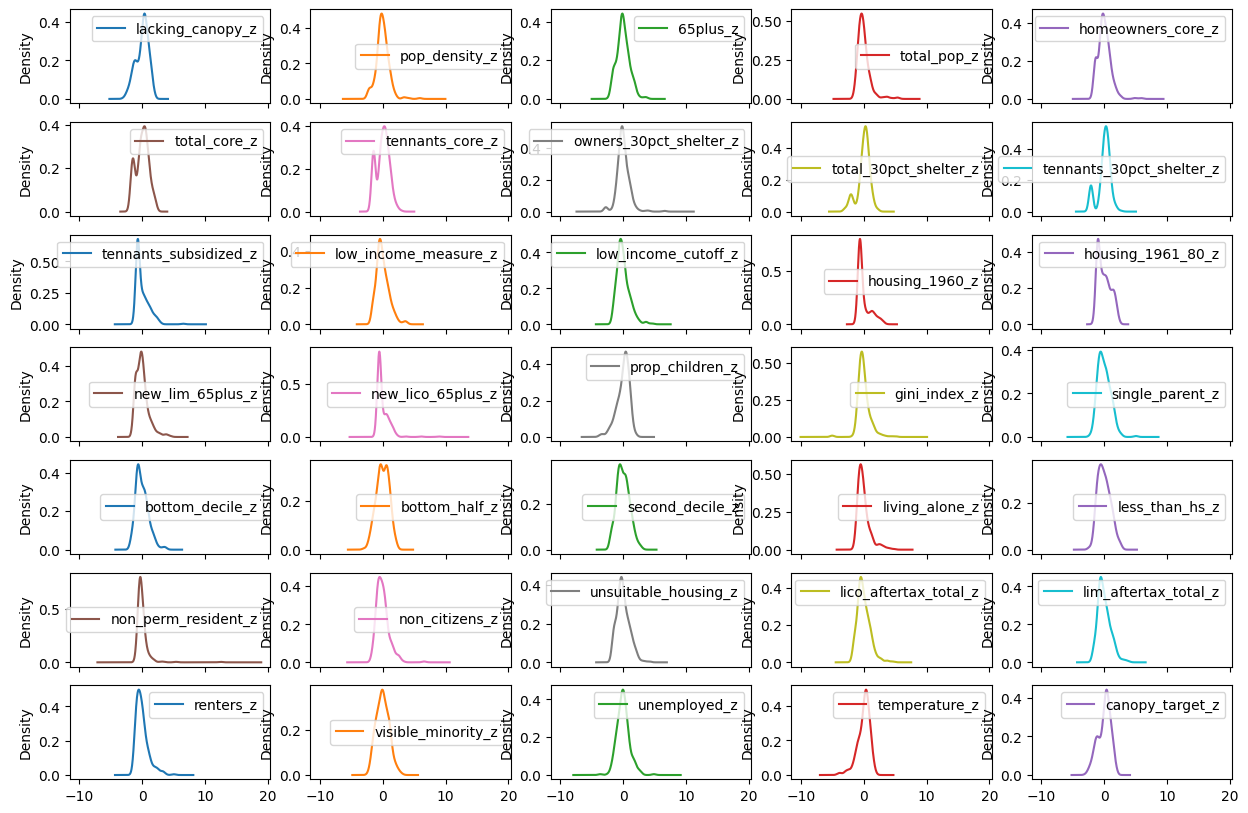

NameError: name 'random_forest' is not defined

In [27]:
# Histograms for each feature
X_z.hist(bins=15, figsize=(15, 10), layout=(7, 5))  # Adjust layout based on the number of features
plt.show()

# Box plots for each feature
X_z.plot(kind='box', subplots=True, layout=(7, 5), figsize=(15, 10))  # Adjust layout
# Pairwise relationships
sns.pairplot(X_z.iloc[:, :5])  # Adjust for selected features
plt.show()

# KDE plots for each feature
X_z.plot(kind='kde', subplots=True, layout=(7, 5), figsize=(15, 10))  # Adjust layout
plt.show()

# Fit the Random Forest model
rf_model.fit(X_z, y)

# Comparing feature importances from Random Forest
feature_importances_rf = pd.Series(random_forest.feature_importances_, index=X_z.columns)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances_rf.values, y=feature_importances_rf.index)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances_rf.values, y=feature_importances_rf.index)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


# Comparing feature importances from PCA
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

c:\Users\toast\Documents\GitHub\spatial_stats\spatial_stats_py\.venv\lib\site-packages\factor_analyzer\factor_analyzer.py:443: RuntimeWarning: invalid value encountered in log
  error = -(np.sum(np.log(values) - values) - n_factors + corr_mtx.shape[0])
c:\Users\toast\Documents\GitHub\spatial_stats\spatial_stats_py\.venv\lib\site-packages\factor_analyzer\factor_analyzer.py:574: UserWarning: Failed to converge: ABNORMAL_TERMINATION_IN_LNSRCH
  warnings.warn(f"Failed to converge: {res.message}")


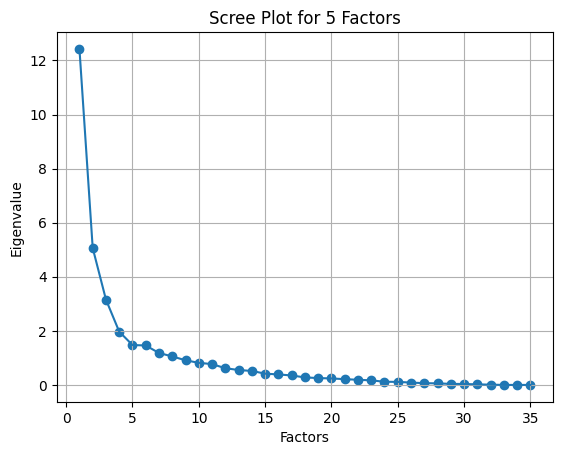

Factor Loadings for 5 Factors:
                          Factor 1  Factor 2  Factor 3  Factor 4  Factor 5
lacking_canopy_z          0.011485  0.990137  0.101856  0.018101  0.059574
pop_density_z             0.384573  0.134546  0.288825  0.176222  0.164439
65plus_z                  0.014837 -0.141029  0.000528  0.025941  0.054082
total_pop_z               0.055616  0.241847  0.285104  0.127904  0.095214
homeowners_core_z         0.645320  0.022182  0.082958 -0.238368  0.701213
total_core_z              0.906008 -0.071501  0.359546 -0.020387  0.070817
tennants_core_z           0.857968 -0.090860  0.395306  0.051578 -0.139012
owners_30pct_shelter_z   -0.004050  0.198368  0.244430  0.463075  0.794524
total_30pct_shelter_z     0.406238 -0.007829  0.872252  0.096907  0.246144
tennants_30pct_shelter_z  0.453880 -0.093949  0.865779 -0.091121 -0.067440
tennants_subsidized_z     0.581027 -0.085952  0.086577  0.022663 -0.130329
low_income_measure_z      0.746413 -0.174547  0.154051  0.450390  0.1

In [28]:
# Import necessary libraries
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import pandas as pd

# Perform Factor Analysis with 5 factors
fa = FactorAnalyzer(n_factors=5, rotation='varimax', method='ml')
fa.fit(X_z)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()

# Plot Scree Plot
plt.scatter(range(1, X_z.shape[1]+1), ev)
plt.plot(range(1, X_z.shape[1]+1), ev)
plt.title('Scree Plot for 5 Factors')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Explanation: The Scree Plot helps determine the number of factors to retain based on the eigenvalues.
# We look for the "elbow" point where the eigenvalues start to level off.
# Factors with eigenvalues greater than 1 are typically considered significant.

# Factor Loadings
loadings = fa.loadings_

# Create a DataFrame to display the factor loadings
loadings_df = pd.DataFrame(loadings, index=X_z.columns, columns=[f'Factor {i+1}' for i in range(5)])
# Print the factor loadings
print("Factor Loadings for 5 Factors:")
print(loadings_df)

# Explanation: Factor loadings represent the correlation between each variable and the factors.
# Higher absolute values indicate a stronger relationship between the variable and the factor.
# Positive values indicate a positive correlation, while negative values indicate a negative correlation.
# The factor loadings help interpret the underlying factors and their relationship with the variables.


In [29]:
# Convert the arrays to 1-dimensional
factor_loadings1 = np.array(loadings).flatten()
xgb_feature_importances1 = np.array(best_xgb_feature_importances).flatten()
rf_feature_importances1 = np.array(rf_feature_importances).flatten()

# Create a DataFrame for xgb_feature_importances and rf_feature_importances
df_xgb_rf = pd.DataFrame({
    'xgb_importances': xgb_feature_importances1,
    'rf_importances': rf_feature_importances1,
}, index=loadings_df.index)

# Merge loadings_df with df_xgb_rf
loadings_df = pd.concat([loadings_df, df_xgb_rf], axis=1)

# Calculate the average weight for each feature
loadings_df['average_weight'] = loadings_df.mean(axis=1)
# Move the 'z_columns' to the leftmost column
#loadings_df = loadings_df[['z_columns'] + [col for col in loadings_df.columns if col != 'z_columns']]

# Now you can use loadings_df['average_weight'] as your weighting array
weighting = loadings_df['average_weight'].values


In [30]:
loadings_df

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,xgb_importances,rf_importances,average_weight
lacking_canopy_z,0.011485,0.990137,0.101856,0.018101,0.059574,0.001876,0.005908,0.169848
pop_density_z,0.384573,0.134546,0.288825,0.176222,0.164439,0.015158,0.018265,0.168861
65plus_z,0.014837,-0.141029,0.000528,0.025941,0.054082,0.001776,0.003880,-0.005712
total_pop_z,0.055616,0.241847,0.285104,0.127904,0.095214,0.007361,0.012178,0.117889
homeowners_core_z,0.645320,0.022182,0.082958,-0.238368,0.701213,0.003890,0.006842,0.174863
total_core_z,0.906008,-0.071501,0.359546,-0.020387,0.070817,0.051497,0.084100,0.197154
tennants_core_z,0.857968,-0.090860,0.395306,0.051578,-0.139012,0.082592,0.048994,0.172367
owners_30pct_shelter_z,-0.004050,0.198368,0.244430,0.463075,0.794524,0.002071,0.005571,0.243427
total_30pct_shelter_z,0.406238,-0.007829,0.872252,0.096907,0.246144,0.027155,0.048681,0.241364
tennants_30pct_shelter_z,0.453880,-0.093949,0.865779,-0.091121,-0.067440,0.004596,0.025684,0.156776


In [31]:
loadings_df['indicator'] = X_z.columns
loadings_df.to_csv('loadings_updated.csv',index=False)

In [32]:
loadings_df

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,xgb_importances,rf_importances,average_weight,indicator
lacking_canopy_z,0.011485,0.990137,0.101856,0.018101,0.059574,0.001876,0.005908,0.169848,lacking_canopy_z
pop_density_z,0.384573,0.134546,0.288825,0.176222,0.164439,0.015158,0.018265,0.168861,pop_density_z
65plus_z,0.014837,-0.141029,0.000528,0.025941,0.054082,0.001776,0.003880,-0.005712,65plus_z
total_pop_z,0.055616,0.241847,0.285104,0.127904,0.095214,0.007361,0.012178,0.117889,total_pop_z
homeowners_core_z,0.645320,0.022182,0.082958,-0.238368,0.701213,0.003890,0.006842,0.174863,homeowners_core_z
total_core_z,0.906008,-0.071501,0.359546,-0.020387,0.070817,0.051497,0.084100,0.197154,total_core_z
tennants_core_z,0.857968,-0.090860,0.395306,0.051578,-0.139012,0.082592,0.048994,0.172367,tennants_core_z
owners_30pct_shelter_z,-0.004050,0.198368,0.244430,0.463075,0.794524,0.002071,0.005571,0.243427,owners_30pct_shelter_z
total_30pct_shelter_z,0.406238,-0.007829,0.872252,0.096907,0.246144,0.027155,0.048681,0.241364,total_30pct_shelter_z
tennants_30pct_shelter_z,0.453880,-0.093949,0.865779,-0.091121,-0.067440,0.004596,0.025684,0.156776,tennants_30pct_shelter_z


In [35]:
# Assuming factor_loadings is a 2D array with shape (34, 5)
# and xgb_feature_importances and rf_feature_importances are 1D arrays with shape (34,)

# Aggregate factor loadings into a single array
factor_loadings_aggregated = np.mean(loadings, axis=1)

# Check if the lengths match
assert len(factor_loadings_aggregated) == len(best_xgb_feature_importances) == len(rf_feature_importances), "Lengths must match"

# Stack the three 1D arrays along a new third axis to create a 3D array
weights_3d = np.stack((factor_loadings_aggregated, best_xgb_feature_importances, rf_feature_importances), axis=1)

# Aggregate the 3D array into a 1D array
weighting = np.mean(weights_3d, axis=1)

# Now you can use this weighting array to calculate the weighted scores
vi_columns_array = df.filter(like='_VI').values
weighted_scores = np.dot(vi_columns_array, weighting)

# Print the weighted scores
print("Weighted Scores for Each Row:")
print(weighted_scores)

Weighted Scores for Each Row:
[13.91292656  9.26739871 11.63733812 10.33224837  9.709057   11.0966588
  9.81305604  7.10412406  7.50107533 10.21102155  8.12258596 12.63941339
 11.25153318 11.9367686  10.00101522  9.33724621  8.26750393 11.18038892
  7.6263753   9.39463299  9.81992151 10.55501314 10.63807544 12.79444524
  8.89749357 11.72187953 10.11086211  7.30153874  9.26041793 11.0289661
 10.30792621 10.24493635 14.39226218 10.02413341  9.55965015  9.73124149
 12.01319593  8.01600647  7.31005855 10.90031597 11.92401278 10.35165265
 11.68780381 13.81391873  6.86214102 10.0999429  13.09442899  9.51600489
  7.30979753 10.63159929  9.49754285  8.5895526  11.59536919  8.40900932
 15.10266946  9.46751303  9.94318601 11.9990309   6.40349276  9.50585991
  8.06069763 12.69221365  9.61466815  9.14247278  8.08602741 10.49115413
  7.24087991  8.7069798  10.01727868 10.75106243  7.83296615  6.17982885
  8.78328045 12.25572833 10.42194927 10.599183   13.0449917  10.1341526
  7.71166841  8.73299031

In [36]:
df['weighted_score'] = weighted_scores

In [38]:
df.to_csv('edm_scores.csv',index=False)

In [53]:

categories = {
    'demographics': [
        'pop_density_z', '65plus_z', 'total_pop_z', 'prop_children_z', 'gini_index_z',
        'single_parent_z', 'living_alone_z', 'less_than_hs_z', 
        'non_perm_resident_z', 'non_citizens_z',
        'renters_z', 'visible_minority_z', 'unemployed_z'
    ],
    'Housing': [
        'homeowners_core_z', 'total_core_z', 'tennants_core_z', 'owners_30pct_shelter_z',
        'total_30pct_shelter_z', 'tennants_30pct_shelter_z', 'tennants_subsidized_z',
        'housing_1960_z', 'housing_1961_80_z', 'unsuitable_housing_z'
    ],
    'Income': [
        'low_income_measure_z', 'low_income_cutoff_z', 'new_lim_65plus_z',
        'new_lico_65plus_z', 'lico_aftertax_total_z', 'lim_aftertax_total_z',
        'bottom_decile_z', 'bottom_half_z', 'second_decile_z'
    ],
    'E_zronment': [
        'lacking_canopy_z', 'temperature_z', 'canopy_target_z'
    ]
}


In [54]:
# Calculate subscores for each category
subscores = {}
for category, columns in categories.items():
    category_weights = loadings_df.loc[columns, 'average_weight'].values
    category_scores = np.dot(df[columns].values, category_weights)
    subscores[category] = category_scores

# Add subscores as columns to df
for category, scores in subscores.items():
    df[f"{category}_subscore"] = scores


In [37]:

# Convert z_columns to a NumPy array and transpose it
z_columns_transposed = np.array(z_columns).T

# Check if z_columns_transposed has more than one dimension
if z_columns_transposed.ndim > 1:
    # Calculate the row-wise aggregation of all columns in z_columns_transposed
    row_aggregation = np.sum(z_columns_transposed, axis=1)

    # Apply the weights to the row-wise aggregation
    weighted_scores = np.dot(row_aggregation, weighting)

    # Print the weighted scores
    print("Weighted Scores for Each Row:")
    print(weighted_scores)
else:
    print("z_columns_transposed does not have more than one dimension.")


z_columns_transposed does not have more than one dimension.


<Axes: >

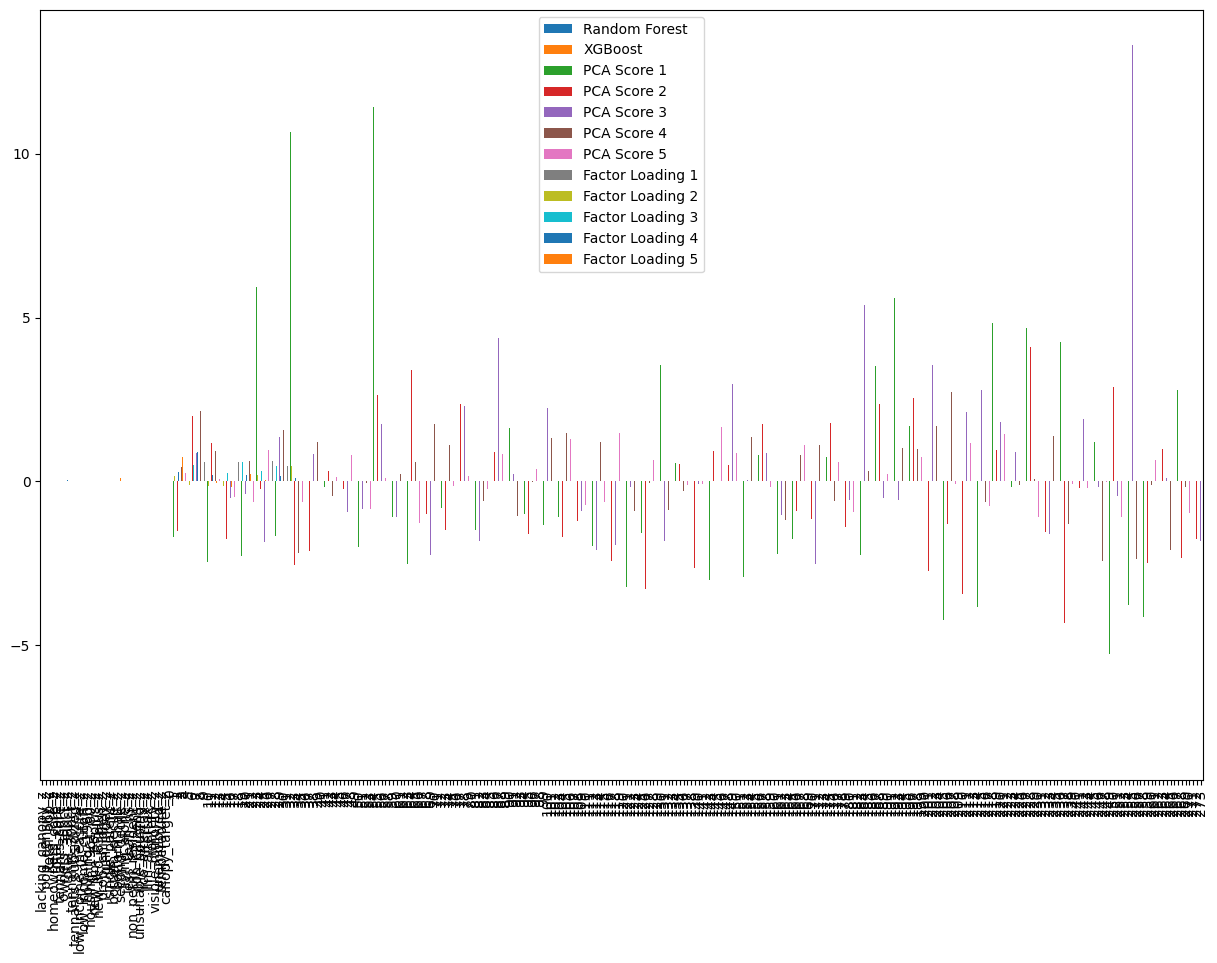

In [48]:
comparison_df.plot(kind='bar', figsize=(15, 10))

In [57]:
# Convert z_columns to a NumPy array
z_columns_array = np.array(z_columns)

# Create a weighting array
# The length of this array should be equal to the number of columns in z_columns
# Replace this with your actual weights
weighting = np.array([0.2, 0.3, 0.5])

# Check if the number of weights matches the number of columns
assert len(weighting) == z_columns_array.shape[1], "Number of weights must match number of columns"

# Apply the weights to the columns and sum them up
weighted_scores = np.dot(z_columns_array, weighting)

# Print the weighted scores
print("Weighted Scores for Each Row:")
print(weighted_scores)

IndexError: tuple index out of range

In [64]:
df_cleaned

,neighbourhood,lacking_canopy_z,pop_density_z,total_pop_z,homeowners_core_z,total_core_z,tennants_core_z,owners_30pct_z,total_30pct_z,tennants_30pct_z,...,unsuitable_housing_z_VI,lico_aftertax_z_VI,lim_aftertax_z_VI,renters_z_VI,visible_minority_z_VI,unemployed_z_VI,temperature_z_VI,canopy_target_z_VI,unweighted_score,weighted_score
0,ABBOTTSFIELD,0.717509,1.001598,-0.688575,1.072485,1.487266,1.405917,0.212180,0.604482,0.586400,...,6,6,6,4,4,3,5,4,158,14.274913
1,ALBANY,1.383038,-0.869779,-0.731552,-0.115825,-0.777320,-0.875576,0.898069,0.289850,-0.063045,...,3,4,3,4,4,3,3,5,112,9.501950
2,ALBERTA AVENUE,-1.545291,0.924028,1.093012,1.459977,1.243387,0.997047,0.261172,0.875065,0.868768,...,4,4,4,4,4,5,3,2,137,11.989768
3,ALDERGROVE,-0.081127,0.381038,0.676918,0.581661,0.546592,0.457339,-0.490040,0.308728,0.558164,...,5,3,3,3,4,4,4,3,124,10.583895
4,ALLARD,1.516144,1.593878,1.917387,-0.451652,-0.352275,-0.270449,0.702101,0.566726,0.332270,...,4,3,3,3,5,3,4,5,119,9.917598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,WILD ROSE,0.983721,1.528428,1.962317,-0.477484,-0.491634,-0.425819,-0.000119,-0.691801,-0.776023,...,5,3,3,3,5,3,4,4,118,9.633274
270,WINDERMERE,0.318191,-0.258107,3.691160,-0.038327,-0.456794,-0.523948,0.783755,0.390532,0.099316,...,3,3,3,3,5,3,4,4,116,9.446358
271,WINDSOR PARK,-2.477033,-0.852810,-0.799924,-1.381633,-1.606507,-1.447993,-0.571693,-0.207268,0.014606,...,3,5,4,3,4,2,2,1,107,8.496619
272,WOODCROFT,-0.613550,-0.514249,-0.325225,0.090838,1.926247,2.231834,-0.147095,1.095307,1.292319,...,3,4,5,5,3,3,3,3,140,12.443395


In [65]:
df_cleaned.to_csv('working_scorecard.csv', index=False)